In [282]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import unicodedata
import seaborn as sns
from scipy import stats

In [283]:
#Si estas desde drive descomenta
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [298]:
path = '/content/drive/MyDrive/DOCTORADO/Materias/Neuro Cognitiva/Respuestas/'
archivos = glob.glob(path + '*.csv')

In [299]:
# Organizamos la data
def normalize_string(s):
    # Convert to lowercase
    s = s.lower()
    # Normalize the string to remove accents
    s = unicodedata.normalize('NFD', s)
    # Remove diacritics (accents)
    s = ''.join(c for c in s if unicodedata.category(c) != 'Mn')
    return s

df_metadata = pd.read_csv(path+'Metadata.csv', sep=';', encoding='latin1')
df_data = df_metadata.rename(columns={'Numero': 'Sujeto'})
df_data['Tiempo Medio Correctas Numeros'] = None
df_data['Tiempo Medio Correctas Imagenes'] = None

#value_mapping = {
#    'Imágenes': normalize_string('Imágenes'),
#    'Numeritos': normalize_string('Numeritos'),
#    'N/A': normalize_string('N/A')}
value_mapping = {
    'ImÃ¡genes': normalize_string('Imágenes'),
    'Numeritos': normalize_string('Numeritos'),
    'N/A': normalize_string('N/A')
}
# Rename the values in the "estim" column
df_data['Primer Estimulo'] = df_data['Primer Estimulo'].replace(value_mapping)

In [300]:
df_metadata

,Numero,Categoria,Primer Estimulo,Unnamed: 3,Unnamed: 4
0,14,Sujetos,ImÃ¡genes,NaN,NaN
1,16,Sujetos,ImÃ¡genes,NaN,NaN
2,18,Sujetos,ImÃ¡genes,NaN,NaN
3,20,Sujetos,ImÃ¡genes,NaN,NaN
4,22,Sujetos,Numeritos,NaN,NaN
5,24,Sujetos,Numeritos,NaN,NaN
6,26,Sujetos,Numeritos,NaN,NaN
7,7,Sujetos,Numeritos,NaN,NaN
8,38,Sujetos,ImÃ¡genes,NaN,NaN
9,102,Sujetos,Numeritos,NaN,NaN


## Tiempos Medios de respuesta

Calculamos los tiempos medios de respuestas correctas para cada experimento. Los agregamos como categorias `df_data['Tiempo Medio Correctas Numeros']` y `df_data['Tiempo Medio Correctas Imagenes']`, respectivamente.



In [301]:
for archivo in archivos:
  if "Metadata" not in archivo:
    df = pd.read_csv(archivo)
    filtered_df = df[df['estim'] <= 5]
    if "numeritos" in archivo:
      df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Tiempo Medio Correctas Numeros'] = filtered_df['response_time'].mean()
    else:
      df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Tiempo Medio Correctas Imagenes'] = filtered_df['response_time'].mean()

Este analisis es para tener una idea de si en lineas generales hubo diferencia entre los dos experimentos. Como vemos en el grafico y el t-test, la respuesta es no. Sin embargo, sí hay diferencia al tener en cuenta a nuestro grupo en el experimento de imagenes.

<ipython-input-302-34d7ebc72248>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Values', data=df, palette=palette)


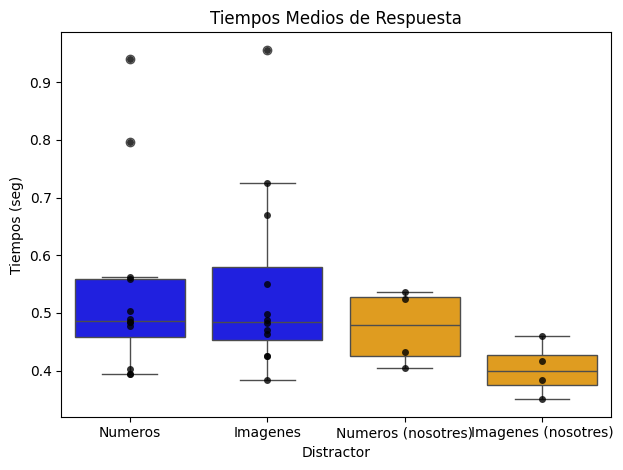

F-statistic: 1.1474741840148779
P-value: 0.3471880956003763


In [302]:
# Example data
data1 = list(df_data.loc[df_data['Categoria'] != 'Nosotres']['Tiempo Medio Correctas Numeros'])
data2 = list(df_data.loc[df_data['Categoria'] != 'Nosotres']['Tiempo Medio Correctas Imagenes'])
data3 = list(df_data.loc[df_data['Categoria'] == 'Nosotres']['Tiempo Medio Correctas Numeros'])
data4 = list(df_data.loc[df_data['Categoria'] == 'Nosotres']['Tiempo Medio Correctas Imagenes'])
#data1 = list(df_data['Tiempo Medio Correctas Numeros'])
#data2 = list(df_data['Tiempo Medio Correctas Imagenes'])
tiempos_medios = {
    'Values': data1 + data2 + data3 + data4,
    'Category': ['Numeros'] * len(data1) + ['Imagenes'] * len(data2) + ['Numeros (nosotres)'] * len(data3) + ['Imagenes (nosotres)'] * len(data4)
}

# Create a DataFrame
df = pd.DataFrame(tiempos_medios)

palette = {'Numeros': 'blue', 'Imagenes': 'blue',
           'Numeros (nosotres)': 'orange', 'Imagenes (nosotres)': 'orange'}

# Create the boxplot
sns.boxplot(x='Category', y='Values', data=df, palette=palette)
# Overlay individual points
sns.stripplot(x='Category', y='Values', data=df, color='black', jitter=False, alpha=0.8)


# Add titles and labels
plt.title('Tiempos Medios de Respuesta')
plt.xlabel('Distractor')
plt.ylabel('Tiempos (seg)')

# Display the plot
plt.tight_layout()
plt.show()

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(data1,data2,data3,data4)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

## Cantidad de errores

Contamos la cantidad de errores cometidos (falsos positivos y falsos negativos)

In [303]:
df_data['Falsos Positivos Numeros'] = None
df_data['Falsos Negativos Numeros'] = None
df_data['Total Errores Numeros'] = None
df_data['Falsos Positivos Imagenes'] = None
df_data['Falsos Negativos Imagenes'] = None
df_data['Total Errores Imagenes'] = None


for archivo in archivos:
  if "Metadata" not in archivo:
    df = pd.read_csv(archivo)
    filteredFN_df = df[df['estim'] <= 5]
    filteredFP_df = df[df['estim'] > 5]
    if "numeritos" in archivo:
      df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Falsos Negativos Numeros'] = sum(np.isnan(filteredFN_df['response_time']))
      df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Falsos Positivos Numeros'] = len(np.isnan(filteredFP_df['response_time'])) - sum(np.isnan(filteredFP_df['response_time']))
      df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Total Errores Numeros'] = df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Falsos Positivos Numeros'] + df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Falsos Negativos Numeros']
    else:
      df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Falsos Negativos Imagenes'] =  sum(np.isnan(filteredFN_df['response_time']))
      df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Falsos Positivos Imagenes'] = len(np.isnan(filteredFP_df['response_time'])) - sum(np.isnan(filteredFP_df['response_time']))
      df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Total Errores Imagenes'] = df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Falsos Positivos Imagenes'] + df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Falsos Negativos Imagenes']



<ipython-input-304-dc59ffa2f59c>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Values', data=df, palette=palette)


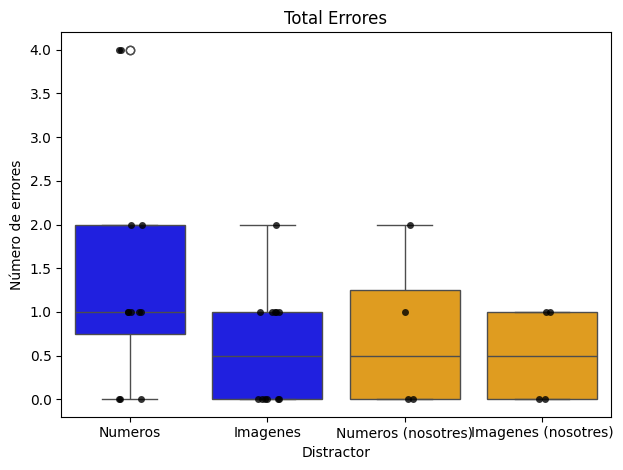

P-value: 0.07288906571546086


In [304]:
# Example data
data1 = list(df_data.loc[df_data['Categoria'] != 'Nosotres']['Total Errores Numeros'])
data2 = list(df_data.loc[df_data['Categoria'] != 'Nosotres']['Total Errores Imagenes'])
data3 = list(df_data.loc[df_data['Categoria'] == 'Nosotres']['Total Errores Numeros'])
data4 = list(df_data.loc[df_data['Categoria'] == 'Nosotres']['Total Errores Imagenes'])
total_errores = {
    'Values': data1 + data2 + data3 + data4,
    'Category': ['Numeros'] * len(data1) + ['Imagenes'] * len(data2) + ['Numeros (nosotres)'] * len(data3) + ['Imagenes (nosotres)'] * len(data4)
}

# Create a DataFrame
df = pd.DataFrame(total_errores)

palette = {'Numeros': 'blue', 'Imagenes': 'blue',
           'Numeros (nosotres)': 'orange', 'Imagenes (nosotres)': 'orange'}

# Create the boxplot
sns.boxplot(x='Category', y='Values', data=df, palette=palette)
# Overlay individual points
sns.stripplot(x='Category', y='Values', data=df, color='black', jitter=True, alpha=0.8)


# Add titles and labels
plt.title('Total Errores')
plt.xlabel('Distractor')
plt.ylabel('Número de errores')

# Display the plot
plt.tight_layout()
plt.show()

t_stat, p_value = stats.ttest_ind(data1, data2)
print(f"P-value: {p_value}")

# Diferencias Entre 1er Trial y 2do Trial

In [305]:
df_data['Tiempo Medio Primera'] = None
df_data['Tiempo Medio Segunda'] = None

for archivo in archivos:
  if "Metadata" not in archivo:
    df = pd.read_csv(archivo)
    filtered_df = df[df['estim'] <= 5]
    if ("numeritos" in archivo) and np.array(df_data.loc[df_data['Sujeto'] == df['subid'][0],'Primer Estimulo'] == "numeritos")[0]:
      df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Tiempo Medio Primera'] = filtered_df['response_time'].mean()
    elif ("imagenes" in archivo) and np.array(df_data.loc[df_data['Sujeto'] == df['subid'][0],'Primer Estimulo'] == "imagenes")[0]:
      df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Tiempo Medio Primera'] = filtered_df['response_time'].mean()
    else:
      df_data.loc[df_data['Sujeto'] == df['subid'][0], 'Tiempo Medio Segunda'] = filtered_df['response_time'].mean()

<ipython-input-310-bc6baf33dc4e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Values', data=df, palette=palette)


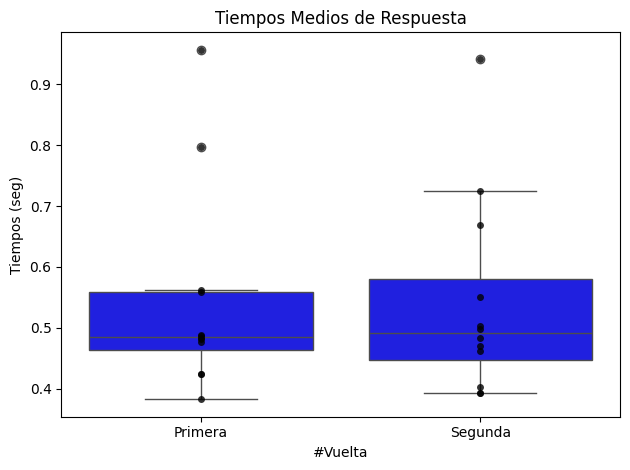

F-statistic: 0.3560096209185063
P-value: 0.7851549639142257


In [310]:
# Example data
data1 = list(df_data.loc[df_data['Categoria'] != 'Nosotres']['Tiempo Medio Primera'])
data2 = list(df_data.loc[df_data['Categoria'] != 'Nosotres']['Tiempo Medio Segunda'])
#data1 = list(df_data['Tiempo Medio Correctas Numeros'])
#data2 = list(df_data['Tiempo Medio Correctas Imagenes'])
tiempos_medios = {
    'Values': data1 + data2,
    'Category': ['Primera'] * len(data1) + ['Segunda'] * len(data2)
}

# Create a DataFrame
df = pd.DataFrame(tiempos_medios)

palette = {'Primera': 'blue', 'Segunda': 'blue'}

# Create the boxplot
sns.boxplot(x='Category', y='Values', data=df, palette=palette)
# Overlay individual points
sns.stripplot(x='Category', y='Values', data=df, color='black', jitter=False, alpha=0.8)


# Add titles and labels
plt.title('Tiempos Medios de Respuesta')
plt.xlabel('#Vuelta')
plt.ylabel('Tiempos (seg)')

# Display the plot
plt.tight_layout()
plt.show()

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(data1,data2,data3,data4)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")